In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss

#survival analysis 
import lifelines

In [2]:

# Load data using Pandas
df = pd.read_csv('..\\speech\\churn_data.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#Data indicating whether an individual’s tenure/duration with the company along with a binary flag representing whether churned or not as at the date of data collection:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Feature Engineering

In [5]:
# Replace single white space with MonthlyCharges and convert to numeric
#TotalCharges is an object datatype
df.iloc[df[df['TotalCharges'] == ' '].index, 19] = df['MonthlyCharges']
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# Save customerID and MonthlyCharges columns in a separate DF and drop it from the main DF since they are 
#a Unique identifier 
churned_customers = df[df['Churn'] == 'No'] #Replace Yes and No values of our target Churn column with 1 and 0, resp.
customerID = pd.DataFrame(churned_customers[['customerID', 'MonthlyCharges']])
df.drop(columns = ['customerID'], inplace=True)

#Similarly, for other specific features, replace Yes with 1 and 0 for other values (e.g., No, No internet service).

# Create a copy of the data DF at this point in time that will be used later to plot categorical Kaplan–Meier Curves
#KM Curves are a non-parametric statistic used to estimate the survival function from lifetime data.
df_kmf = df.copy()

# Convert remaining categorical features into dummy variables later on
#For each dummy variable, we typically drop one of the encoded features to eliminate the risk of multicollinearity.
# Recheck our feature engineering done so far
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


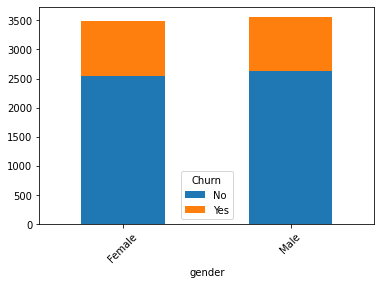

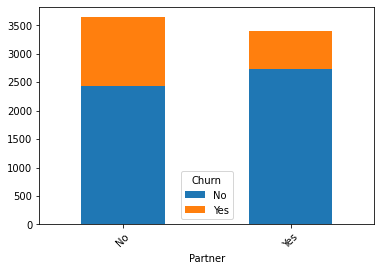

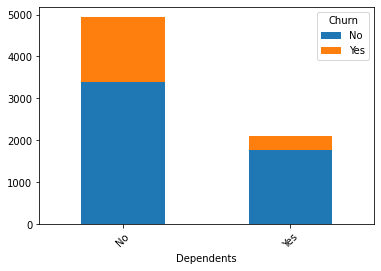

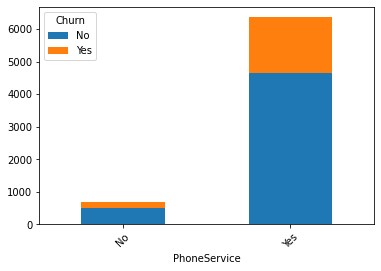

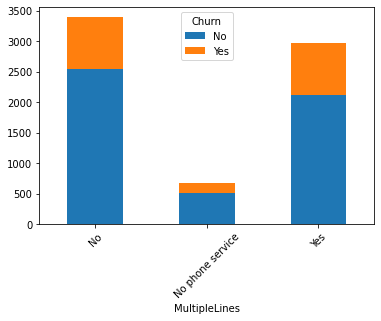

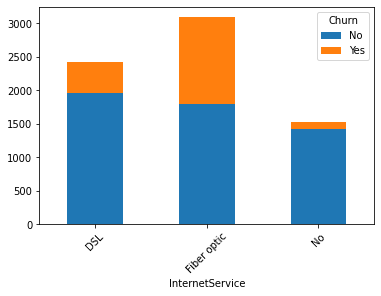

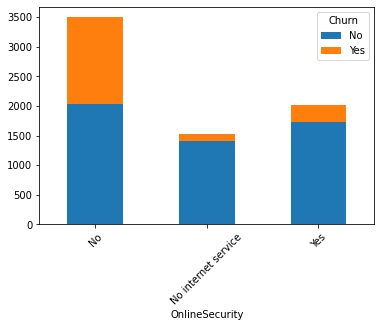

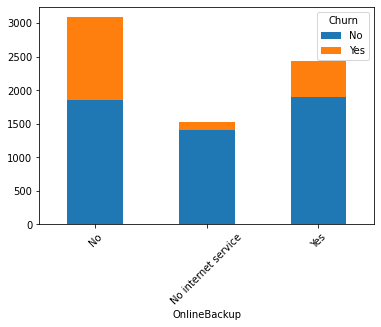

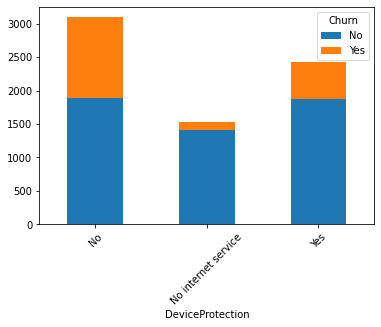

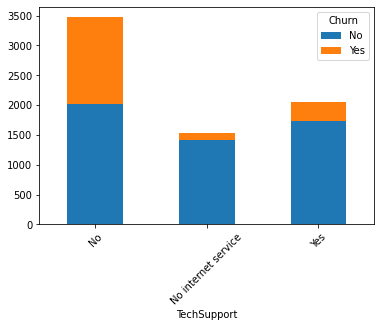

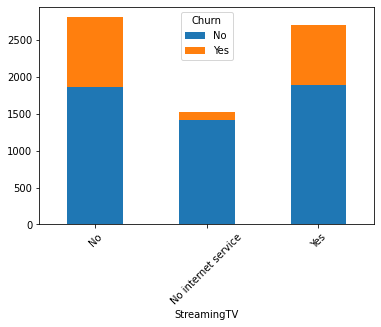

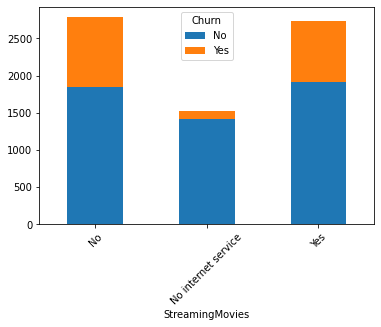

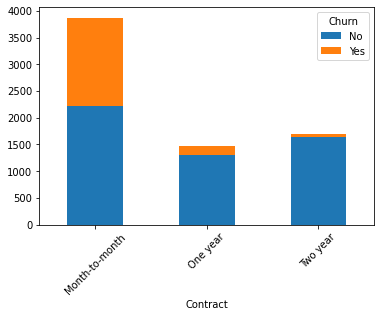

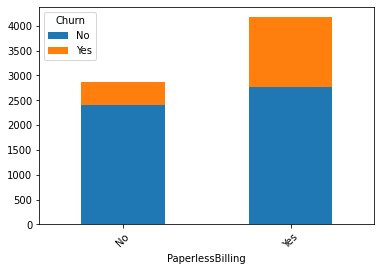

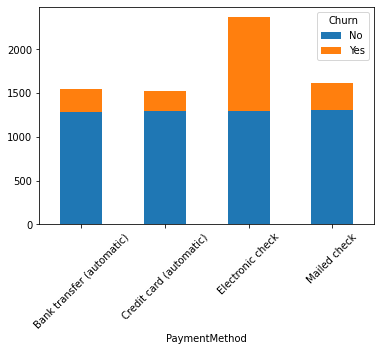

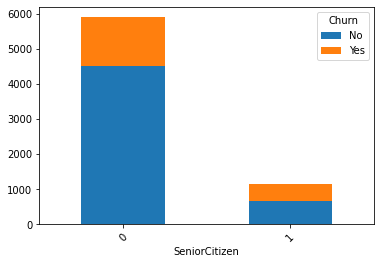

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.798992
std,0.368612,24.559481,30.090047,2266.730170
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [6]:
columns_to_visualise = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

for column in columns_to_visualise:
    plot_df = df.groupby([column, 'Churn']).size().reset_index().pivot(columns='Churn', index=column, values=0)
    plot_df.plot.bar(stacked=True, rot = 45)
    
plt.show()
df.describe()

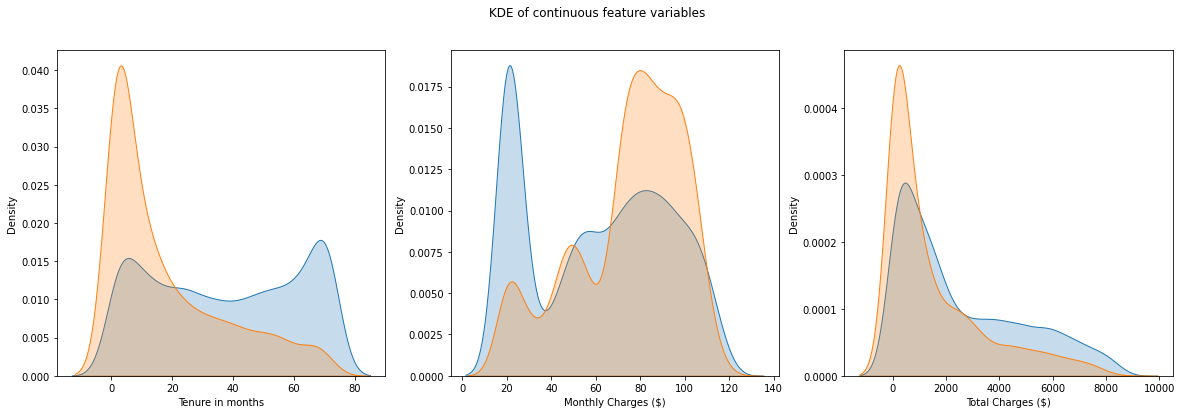

In [7]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,6))
fig.suptitle("KDE of continuous feature variables")
# tenure
sns.kdeplot(df['tenure'].loc[df['Churn'] == 'No'], label='not churn', shade=True, ax = ax1)
sns.kdeplot(df['tenure'].loc[df['Churn'] == 'Yes'], label='churn', shade=True, ax = ax1)
ax1.set_xlabel("Tenure in months")
# monthly charges
sns.kdeplot(df['MonthlyCharges'].loc[df['Churn'] == 'No'], label='not churn', shade=True, ax = ax2)
sns.kdeplot(df['MonthlyCharges'].loc[df['Churn'] == 'Yes'], label='churn', shade=True, ax = ax2)
ax2.set_xlabel("Monthly Charges ($)")
# total charges
sns.kdeplot(df['TotalCharges'].loc[df['Churn'] == 'No'], label='not churn', shade=True, ax = ax3)
sns.kdeplot(df['TotalCharges'].loc[df['Churn'] == 'Yes'], label='churn', shade=True, ax = ax3)
ax3.set_xlabel("Total Charges ($)");

In [8]:
#kernel density estimate (KDE) plots of continuous variables depict skewed distributions

C:\Users\bhise\Anaconda3\envs\speech\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
C:\Users\bhise\Anaconda3\envs\speech\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
C:\Users\bhise\Anaconda3\envs\speech\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


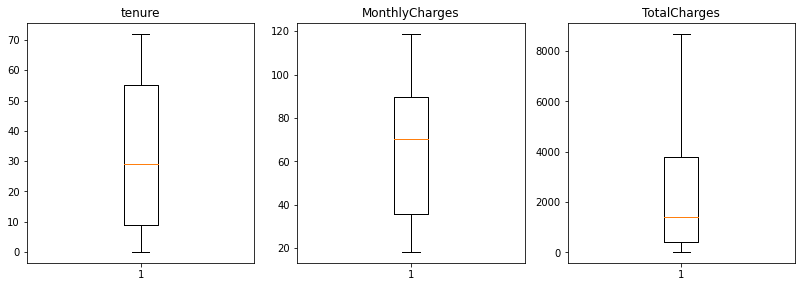

In [9]:
# Check for any outliers in any of the continuous variables
continuous_labels = ['tenure', 'MonthlyCharges', 'TotalCharges']
i = 1
plt.figure(figsize=(15,15))
for var in continuous_labels: #plotting boxplot for each variable
   plt.subplot(round(len(continuous_labels),0)/3+3,4,i)
   plt.boxplot(df[var],whis=5)
   plt.title(var)
   i+=1
plt.tight_layout()

In [10]:
# Convert Churn column to 1 (Yes) or 0 (No)
df['Churn'] = df['Churn'].replace({"No": 0, "Yes": 1})

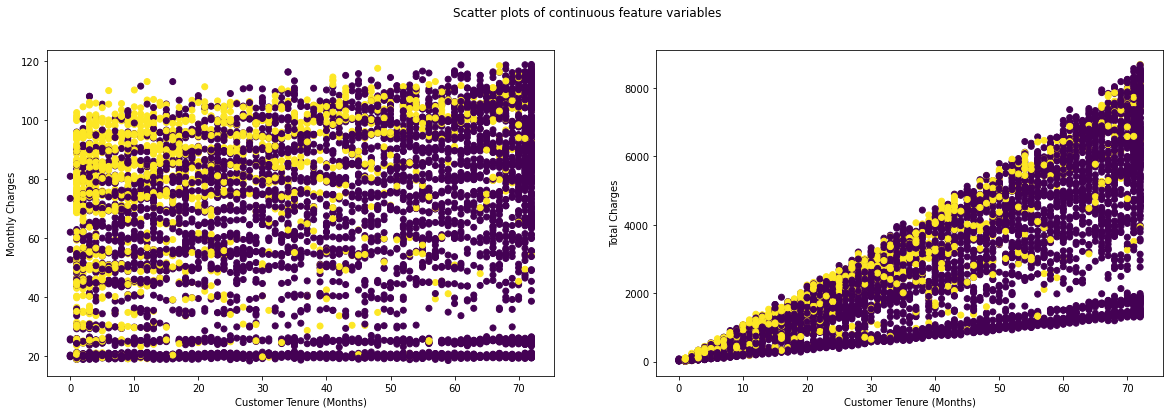

In [11]:
# Visualise scatter plots of tenure against monthly and total charges based on churn

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))
fig.suptitle("Scatter plots of continuous feature variables")

# Monthly Charges
ax1.scatter(df['tenure'], df['MonthlyCharges'], c=df['Churn']) 
ax1.set_xlabel('Customer Tenure (Months)')
ax1.set_ylabel('Monthly Charges')

# Total Charges
ax2.scatter(df['tenure'], df['TotalCharges'], c=df['Churn']) 
ax2.set_xlabel('Customer Tenure (Months)')
ax2.set_ylabel('Total Charges');

In [12]:
# Create a list of features that we want to engineer as above
features_to_combine = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Assign 1 to Yes and 0 otherwise
for feat in features_to_combine:
    df[feat] = df[feat].apply(lambda x: 1 if x == 'Yes' else 0)

In [13]:
# Generate dummy variables for our remaining categorical columns
df = pd.get_dummies(df, columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod'], drop_first = False)
# Drop that dummy variable that the business considers to be typical of their subscribers
df.drop(columns = ['gender_Male', 'Partner_Yes', 'Dependents_No', 'PhoneService_Yes', 'InternetService_Fiber optic', 'Contract_Month-to-month', 'PaperlessBilling_Yes', 'PaymentMethod_Electronic check'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7043 non-null   int64  
 1   tenure                                   7043 non-null   int64  
 2   MultipleLines                            7043 non-null   int64  
 3   OnlineSecurity                           7043 non-null   int64  
 4   OnlineBackup                             7043 non-null   int64  
 5   DeviceProtection                         7043 non-null   int64  
 6   TechSupport                              7043 non-null   int64  
 7   StreamingTV                              7043 non-null   int64  
 8   StreamingMovies                          7043 non-null   int64  
 9   MonthlyCharges                           7043 non-null   float64
 10  TotalCharges                             7043 no

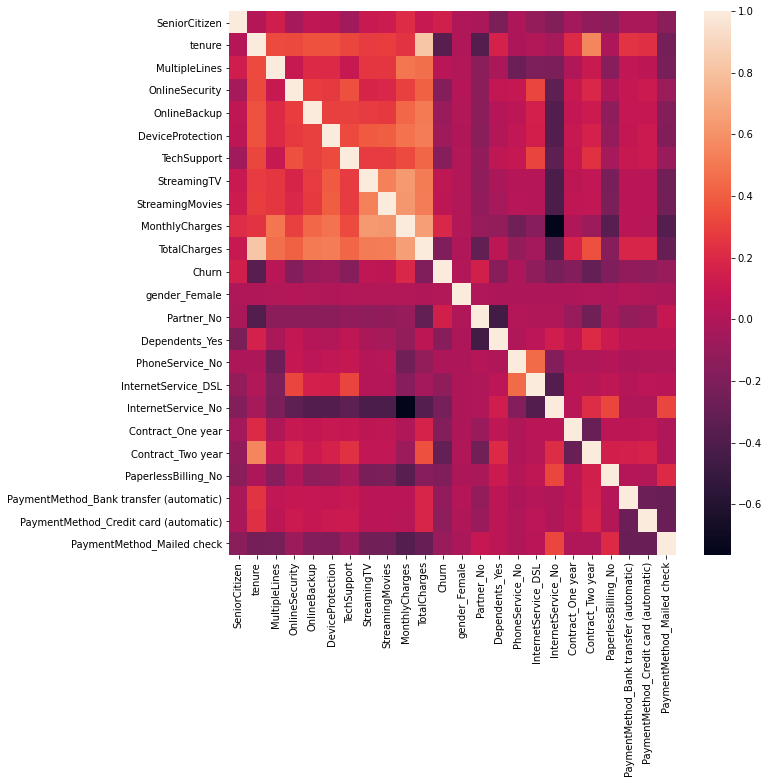

In [14]:
#The Cox Proportional Hazards (CPH) model implementation in lifelines does not work well with highly collinear covariates
# Let's check for multicollinearity as it is a basic assumption of the CPH model
fig = plt.figure(figsize=(10,10))
corrmat = df.corr()
sns.heatmap(corrmat);

In [15]:
#Since above heatmap does not indicate any high pair-wise correlation, we will continue with our survival analysis.

# KM Curves

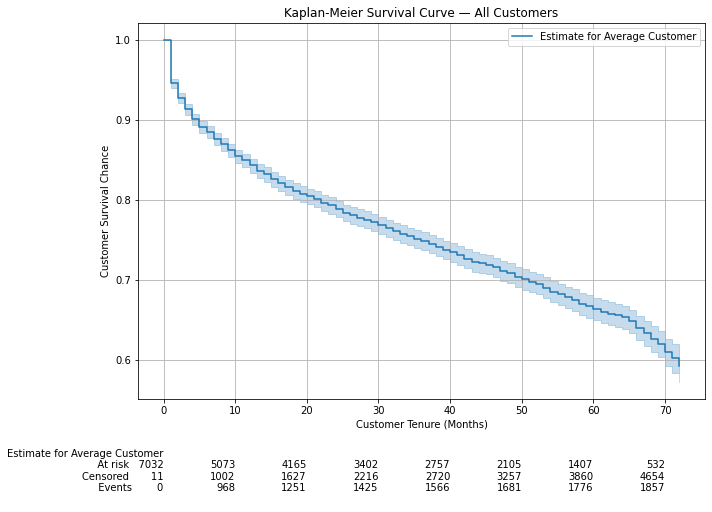

In [16]:
# Getting the survival analysis started by first plotting a KM curve from the sample that shows historical survival 
#probability of an average customer at specific points in time
# Instantiate KMF class with the default 5% Cnfidence Intervals, can be changed through alpha parameter
kmf = lifelines.KaplanMeierFitter()

# Fit KMF to our data
kmf.fit(durations = df['tenure'], event_observed = df['Churn'], label = 'Estimate for Average Customer')

# Plot KM curve
fig, ax = plt.subplots(figsize = (10,7))
kmf.plot(at_risk_counts = True, ax=ax)
ax.set_title('Kaplan-Meier Survival Curve — All Customers')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
ax.grid();

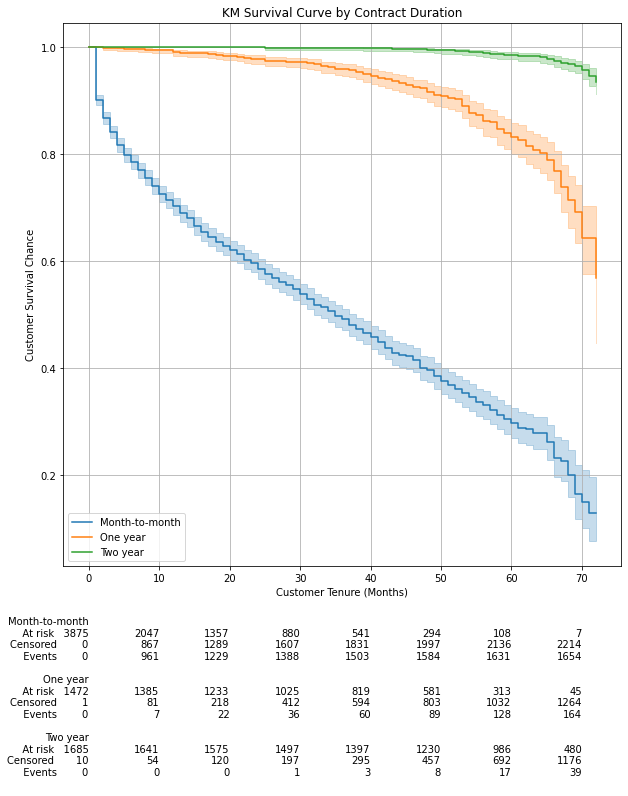

In [17]:
# Update Churn column of data_kmf that we kept aside for this moment before feature engineering
df_kmf['Churn'] = df_kmf['Churn'].replace({"No": 0, "Yes": 1})

# save indices for each contract type
idx_m2m = df_kmf['Contract'] == 'Month-to-month'
idx_1y = df_kmf['Contract'] == 'One year'
idx_2y = df_kmf['Contract'] == 'Two year'

# plot the 3 KM plots for each category
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10))
kmf_m2m = lifelines.KaplanMeierFitter()
ax = kmf_m2m.fit(durations = df_kmf.loc[idx_m2m, 'tenure'], event_observed = df_kmf.loc[idx_m2m, 'Churn'], label = 'Month-to-month').plot(ax = ax)
kmf_1y = lifelines.KaplanMeierFitter()
ax = kmf_1y.fit(durations = df_kmf.loc[idx_1y, 'tenure'], event_observed = df_kmf.loc[idx_1y, 'Churn'], label = 'One year').plot(ax = ax)
kmf_2y = lifelines.KaplanMeierFitter()
ax = kmf_2y.fit(durations = df_kmf.loc[idx_2y, 'tenure'], event_observed = df_kmf.loc[idx_2y, 'Churn'], label = 'Two year').plot(ax = ax)

# display title and labels
ax.set_title('KM Survival Curve by Contract Duration')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()

# display at-risk counts for each category
lifelines.plotting.add_at_risk_counts(kmf_m2m, kmf_1y, kmf_2y, ax = ax);

# CPH Model Training

In [18]:
# Instantiate and fit CPH model
cph = lifelines.CoxPHFitter()
cph.fit(df, duration_col = 'tenure', event_col = 'Churn')

# Print model summary
cph.print_summary(model = 'base model', decimals = 3, columns = ['coef', 'exp(coef)', 'p'])

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12659.693
         time fit was run = 2020-11-13 14:04:41 UTC
                    model = base model

---
                                          coef  exp(coef)       p
covariate                                                        
SeniorCitizen                            0.034      1.035   0.543
MultipleLines                            0.087      1.091   0.489
OnlineSecurity                          -0.213      0.808   0.109
OnlineBackup                            -0.056      0.946   0.661
DeviceProtection                         0.088      1.092   0.489
TechSupport                             -0.084      0.919   0.524
StreamingTV                              0.281      1.325   0.233
StreamingMovies                          0.287      1.332   0.224
MonthlyCharges                           0.013      1.013   0.567
TotalCharges                            -0.002      0.998 <0.0005
gender_Female                            0.039      1.040   0.398
Partner_No                               0.178      1.195   0.001
Dependents_Yes                          -0.092      0.913   0.190
PhoneService_No                         -0.828      0.437   0.081
InternetService_DSL                     -1.017      0.362   0.079
InternetService_No                      -3.356      0.035   0.004
Contract_One year                       -1.266      0.282 <0.0005
Contract_Two year                       -3.701      0.025 <0.0005
PaperlessBilling_No                     -0.150      0.861   0.008
PaymentMethod_Bank transfer (automatic) -0.387      0.679 <0.0005
PaymentMethod_Credit card (automatic)   -0.399      0.671 <0.0005
PaymentMethod_Mailed check               0.123      1.131   0.077
---
Concordance = 0.929
Partial AIC = 25363.386
log-likelihood ratio test = 5986.693 on 22 df
-log2(p) of ll-ratio test = inf

The ``p_value_threshold`` is set at 0.001. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic      p  -log2(p)
Contract_One year                       km            115.75 <0.005     87.26
                                        rank          102.16 <0.005     77.37
Contract_Two year                       km            152.13 <0.005    113.70
                                        rank          122.65 <0.005     92.28
Dependents_Yes                          km              0.19   0.66      0.59
                                        rank            0.19   0.66      0.60
DeviceProtection                        km              0.26   0.61      0.71
                                        rank            1.12   0.29      1.79
InternetService_DSL                     km              0.66   0.42      1.26
                                        rank            1.79   0.18      2.47
InternetService_No                      km              3.06   0.08      3.64
                                        rank            5.38   0.02      5.62
MonthlyCharges                          km              0.33   0.57      0.82
                                        rank            0.08   0.78      0.35
MultipleLines                           km              0.58   0.45      1.17
                                        rank            2.44   0.12      3.08
OnlineBackup                            km              0.70   0.40      1.31
                                        rank            1.81   0.18      2.49
OnlineSecurity                          km              0.56   0.45      1.14
                                        rank            2.06   0.15      2.72
PaperlessBilling_No                     km              0.41   0.52      0.93
                                        rank            0.76   0.38      1.39
Partner_No                              km              2.66   0.10      3.28
                                        rank            4.72   0.03      5.07
PaymentMethod_Bank transfer (automatic) km              0.14   0.71      0.50
                                        rank            0.06   0.81      0.31
PaymentMethod_Credit card (automatic)   km              1.22   0.27      1.90
                                        rank            2.37   0.12      3.02
PaymentMethod_Mailed check              km              0.57   0.45      1.15
                                        rank            1.76   0.18      2.44
PhoneService_No                         km              0.83   0.36      1.47
                                        rank            2.26   0.13      2.92
SeniorCitizen                           km              3.62   0.06      4.13
                                        rank            2.03   0.15      2.70
StreamingMovies                         km              0.47   0.49      1.02
                                        rank            1.41   0.23      2.09
StreamingTV                             km              0.81   0.37      1.45
                                        rank            1.91   0.17      2.58
TechSupport                             km              1.18   0.28      1.85
                                        rank            2.93   0.09      3.53
TotalCharges                            km            154.94 <0.005    115.74
                                        rank           20.49 <0.005     17.35
gender_Female                           km              0.00   0.98      0.03
                                        rank            0.16   0.69      0.54



1. Variable 'TotalCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'TotalCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'TotalCharges' using pd.cut, and then specify it in
`strata=['TotalCharges', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Contract_One year' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_One year', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May tak

[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.0000)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0000)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0000)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0000)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0000)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0000)'>]]

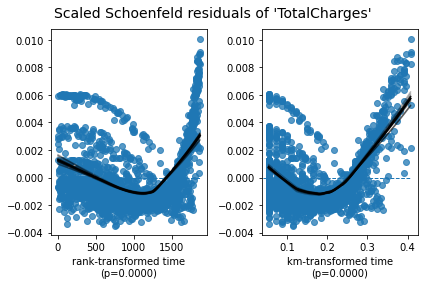

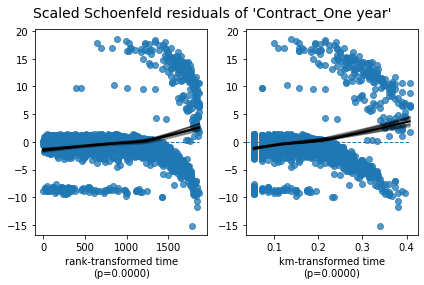

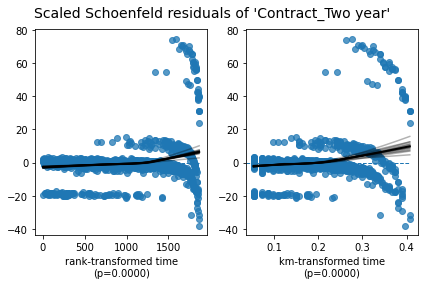

In [19]:
# Check model assumptions for Confirm Proportional Hazards(CH), with a threshold of 0.001 (i.e. only highlight extreme significances - rationale explained after the results)
cph.check_assumptions(df, p_value_threshold=0.001, show_plots=True)

# Model Validation
Notice that we trained the CPH model on our entire dataset, instead of doing so on a training subset as per the standard machine learning pipeline. Let's take care of this now and be more confident our fitted model through doing k-fold cross validation next.

In [20]:
# The Lifelines library has a built-in function to perform k-fold cross-validation of our fitted model.Calculate the average Concordance Index of 5 folds
avg_score = np.mean(lifelines.utils.k_fold_cross_validation(cph, df, 'tenure', 'Churn', k = 10, scoring_method = 'concordance_index'))
print('The average Concordance Score across 10 folds is: {:.3f}'.format(avg_score))

The average Concordance Score across 10 folds is: 0.928


# Check Model Calibration

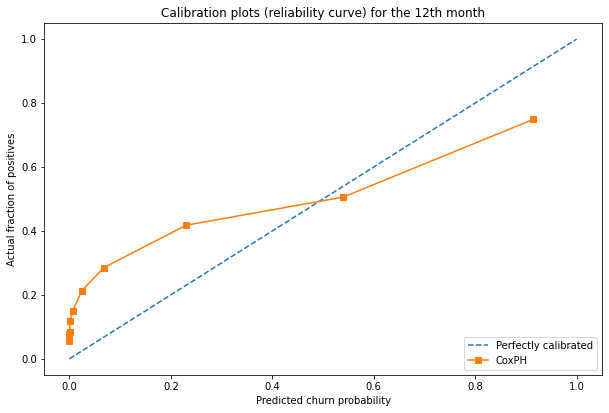

In [21]:
#Calibration curve to check propensity of our model to predict probabilities at any given time correctly.
plt.figure(figsize=(10, 10))
 
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2) 

# Plot the perfectly calibrated line with 0 intercept and 1 slope
ax1.plot([0, 1], [0, 1], ls = '--', label = 'Perfectly calibrated') 

# Calculate the churn probabilities at the end of 12th month. predict_survival_function gives us the survival probability, which we have deducted from 1 to get the churn probability
probs = 1 - np.array(cph.predict_survival_function(df, times = 12).T)

actual = df['Churn'] 
# For each decile, the calibration curve will plot the mean predicted churn probability on the x-axis and its corresponding proportion of observations that actually churned on y-axis, in each bin
fraction_of_positives, mean_predicted_value = calibration_curve(actual, probs, n_bins = 10, strategy = 'quantile') 
ax1.plot(mean_predicted_value, fraction_of_positives, marker = 's', ls = '-', label='CoxPH') 

ax1.set_ylabel("Actual fraction of positives") 
ax1.set_xlabel("Predicted churn probability")
ax1.set_ylim([-0.05, 1.05]) 
ax1.legend(loc="lower right") 
ax1.set_title('Calibration plots (reliability curve) for the 12th month');

In [22]:
#A score function that measures the accuracy of probabilistic predictions
# calculate Brier Score ((0 is an ideal Brier Score))
brier_score = brier_score_loss(df['Churn'], 1 - np.array(cph.predict_survival_function(df, times = 12).T), pos_label = 1)
print('The Brier Score of our CPH Model is {:.2f} at the end of 12 months'.format(brier_score))

The Brier Score of our CPH Model is 0.17 at the end of 12 months


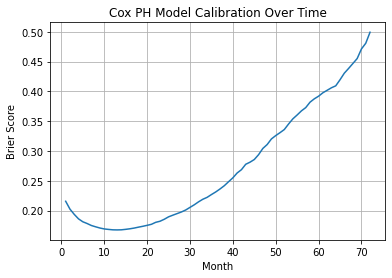

In [23]:
brier_score_dict = {} 
# Loop over all the months
for i in range(1,73): 
    score = brier_score_loss(df['Churn'], 1 - np.array(cph.predict_survival_function(df, times = i).T), pos_label=1) 
    brier_score_dict[i] = [score] 
# Convert the dict to a DF
brier_score_df = pd.DataFrame(brier_score_dict).T 
# Plot the Brier Score over time
fig, ax = plt.subplots()
ax.plot(brier_score_df)
ax.set(xlabel='Month', ylabel='Brier Score', title='Cox PH Model Calibration Over Time') 
ax.grid()

# CPH Model Visualisation

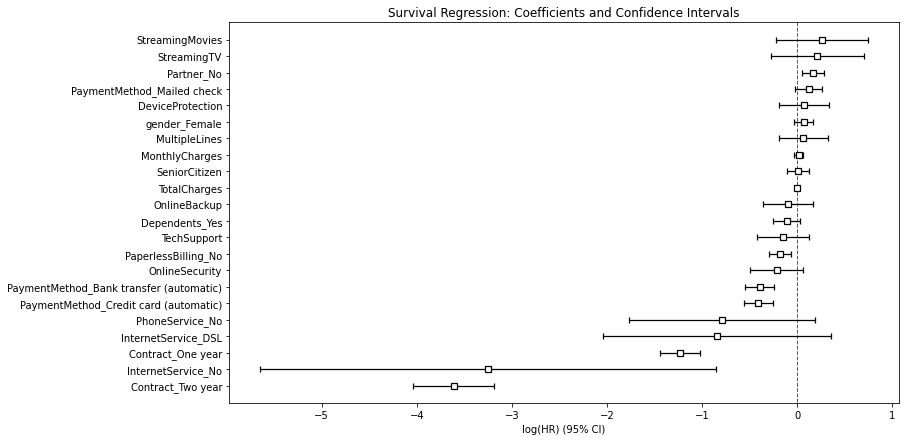

In [24]:
# Let's plot the coefficient outputs and their respective confidence intervals
fig_coef, ax_coef = plt.subplots(figsize = (12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confidence Intervals')
cph.plot(ax = ax_coef);

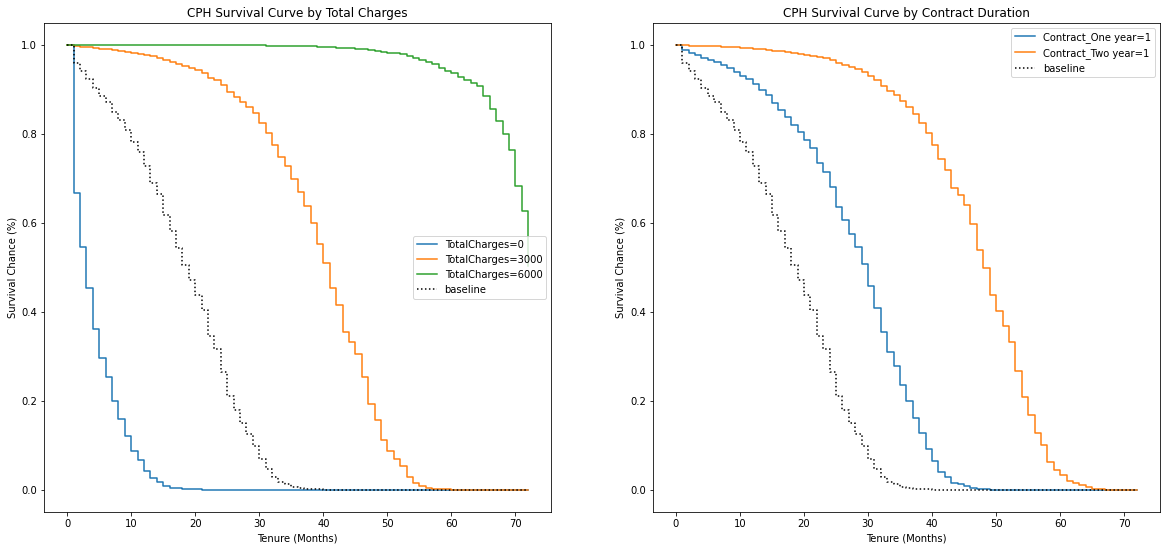

In [25]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,9))
# Total Charges
cph.plot_partial_effects_on_outcome('TotalCharges', values = [0, 3000, 6000], ax = ax1)
ax1.set_title('CPH Survival Curve by Total Charges')
ax1.set_xlabel('Tenure (Months)')
ax1.set_ylabel('Survival Chance (%)')

# Contract
cph.plot_partial_effects_on_outcome(['Contract_One year', 'Contract_Two year'], values = [[1, 0], [0, 1]], ax = ax2) # we have two arrays in values, 1 for each of the covariate. eq to np.eye(2)
ax2.set_title('CPH Survival Curve by Contract Duration')
ax2.set_xlabel('Tenure (Months)')
ax2.set_ylabel('Survival Chance (%)');

# Churn Prevention¶
So now we know which covariates we can focus on to reduce churn of our existing right-censored customers, i.e. those that have not churned yet. 
Through these plots, we can identify specific customer characteristics critical to predicting churn.
• Covariates likely to result in churn:
• Streaming TV and Movies subscriptions
• Multiple phone lines
• Device protection subscription
• Individuals living alone
• Payments by mailed chequesThese features are:

• Right off the bat - Having a 1 or 2 year contract term 
• Automatic payment methods
• No internet and phone services
• DSL internet service
•Paperless billing
• KM Curves
Let us first draw the historical KM curves of the above shortlisted features that we should focus on

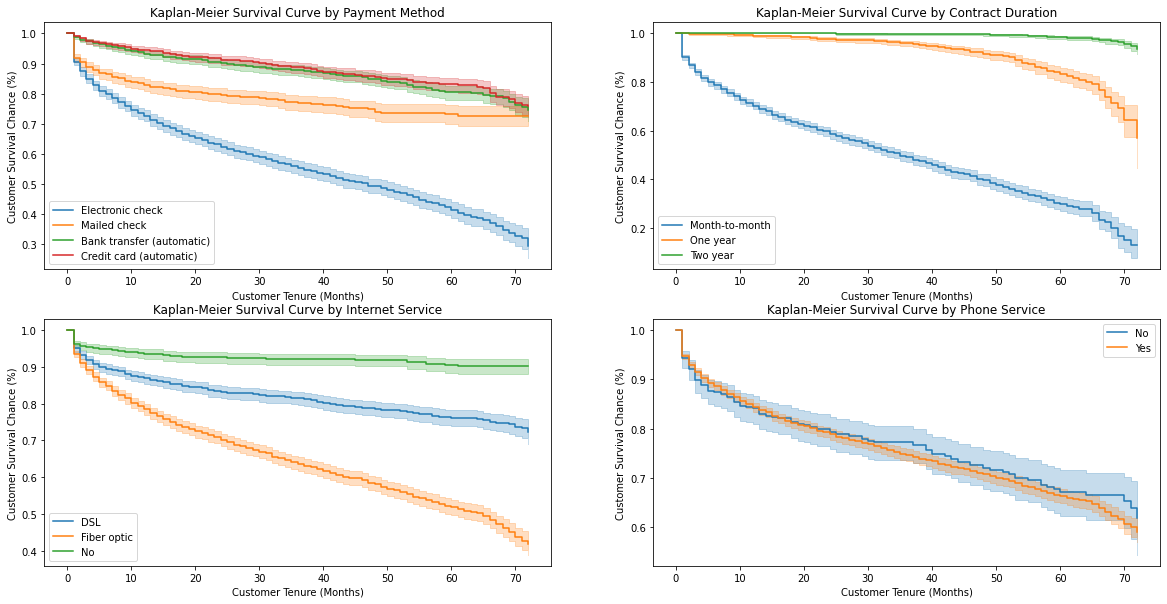

In [26]:
# Now that we know which covariates to focus out attention to reduce churn risk of our existing right-censored customers, 
#i.e., those that have not churned yet. 
# function for creating KM curves segmented by categorical variables
def plot_categorical_KM_Curve(feature, t='tenure', event='Churn', df=df_kmf, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

# call the above function and plot 4 KM Curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(20,10))
# PaymentMethod
plot_categorical_KM_Curve(feature='PaymentMethod', ax=ax1)
ax1.set_title('Kaplan-Meier Survival Curve by Payment Method')
ax1.set_xlabel('Customer Tenure (Months)')
ax1.set_ylabel('Customer Survival Chance (%)')

# Contract
plot_categorical_KM_Curve(feature='Contract', ax=ax2)
ax2.set_title('Kaplan-Meier Survival Curve by Contract Duration')
ax2.set_xlabel('Customer Tenure (Months)')
ax2.set_ylabel('Customer Survival Chance (%)')

# InternetService
plot_categorical_KM_Curve(feature='InternetService', ax=ax3)
ax3.set_title('Kaplan-Meier Survival Curve by Internet Service')
ax3.set_xlabel('Customer Tenure (Months)')
ax3.set_ylabel('Customer Survival Chance (%)')

# PhoneService
plot_categorical_KM_Curve(feature='PhoneService', ax=ax4)
ax4.set_title('Kaplan-Meier Survival Curve by Phone Service')
ax4.set_xlabel('Customer Tenure (Months)')
ax4.set_ylabel('Customer Survival Chance (%)');

# CPH Model
Let's now drill down a bit more and focus on censored subjects, i.e. those who have not churned yet. We will predict the future survival function of our censored (not churned) customers - the new timeline is the remaining duration of the customer, i.e. normalized back to starting at 0. After filtering THE data for all customers where Churn == 0, we will use the predict_survival_function method to predict future survival curves of these customers given their respective covariates. That is, estimate the remaining life of our customers.

In [27]:
# Filter censored customers
censored_df = df[df['Churn'] == 0]
# Carve out the tenure column for each customer
censored_df_last_obs = censored_df['tenure']
# Predict the survival function for each customer from this day onwards
conditioned_sf = cph.predict_survival_function(censored_df, conditional_after = censored_df_last_obs)
conditioned_sf

,0,1,3,6,7,9,10,11,12,14,...,7030,7031,7033,7035,7036,7037,7038,7039,7040,7042
0.0,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000e+00,...,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.0,1.000000e+00,1.0,1.000000e+00,1.000000
1.0,9.861304e-01,9.797694e-01,0.982988,9.635278e-01,9.878080e-01,0.982631,0.972039,0.999917,0.994774,9.527587e-01,...,9.968978e-01,0.983754,9.073320e-01,0.939943,9.912425e-01,1.0,9.843531e-01,1.0,9.858495e-01,0.999669
2.0,9.732555e-01,9.598413e-01,0.957771,8.964204e-01,9.690332e-01,0.968212,0.919750,0.999822,0.990194,9.066200e-01,...,9.931846e-01,0.969254,8.191224e-01,0.878773,9.850120e-01,1.0,9.729360e-01,1.0,9.691916e-01,0.999256
3.0,9.580144e-01,9.359406e-01,0.939789,8.148411e-01,9.470511e-01,0.917028,0.877849,0.999736,0.983562,8.597823e-01,...,9.898676e-01,0.941356,7.114794e-01,0.769045,9.729760e-01,1.0,9.613628e-01,1.0,9.574239e-01,0.998764
4.0,9.445540e-01,9.085899e-01,0.909781,7.593090e-01,9.316007e-01,0.850748,0.834999,0.999644,0.978149,8.012432e-01,...,9.872749e-01,0.921347,6.409347e-01,0.713796,9.629409e-01,1.0,9.491477e-01,1.0,9.348884e-01,0.997530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68.0,3.349788e-157,6.846938e-21,0.000150,6.280475e-240,1.562740e-252,0.264729,0.000000,0.191685,0.614665,1.149644e-164,...,2.730357e-53,0.127952,1.805124e-50,0.000000,3.008809e-97,1.0,2.964370e-40,1.0,9.848408e-188,0.994228
69.0,4.621243e-223,6.846938e-21,0.000150,6.280475e-240,1.562740e-252,0.264729,0.000000,0.191685,0.614665,1.149644e-164,...,4.924929e-65,0.127952,1.805124e-50,0.000000,3.008809e-97,1.0,2.964370e-40,1.0,9.848408e-188,0.994228
70.0,9.815023e-273,6.846938e-21,0.000150,6.280475e-240,1.562740e-252,0.264729,0.000000,0.191685,0.614665,1.149644e-164,...,4.653462e-95,0.127952,1.805124e-50,0.000000,3.008809e-97,1.0,2.964370e-40,1.0,9.848408e-188,0.994228
71.0,0.000000e+00,6.846938e-21,0.000150,6.280475e-240,1.562740e-252,0.264729,0.000000,0.191685,0.614665,1.149644e-164,...,4.653462e-95,0.127952,1.805124e-50,0.000000,3.008809e-97,1.0,2.964370e-40,1.0,9.848408e-188,0.994228


In [28]:
# Predict the month where the survival probability falls below the median
predictions_50 = lifelines.utils.median_survival_times(conditioned_sf)
predictions_50
# Use the following if we wanted to assign any other threshold, i.e. month when the survival function reaches the qth percentile
# predictions_25 = lifelines.utils.qth_survival_times(0.25, conditioned_sf) # 25% survival chance

,0,1,3,6,7,9,10,11,12,14,...,7030,7031,7033,7035,7036,7037,7038,7039,7040,7042
0.5,21.0,14.0,15.0,9.0,17.0,9.0,11.0,54.0,inf,8.0,...,32.0,14.0,6.0,7.0,23.0,inf,18.0,inf,19.0,inf


In [29]:
# We can use this single row and by joining it to our data DF, we can investigate the predicted remaining value a customer has for the business
# Note that we will also append our censored customerIDs that we kept aside at the beginning of the model so as to properly identify our customers
customer_predictions = pd.concat([customerID[['customerID', 'MonthlyCharges']], predictions_50.T], axis = 1)

# Rename the column returned by median_survival_times function
customer_predictions.rename(columns = {0.5: 'Exp_Churn_Month'}, inplace = True)

# Add another column for the expected loss if these customers were to leave us today
customer_predictions['Exp_Loss'] = customer_predictions['MonthlyCharges'] * customer_predictions['Exp_Churn_Month']
customer_predictions

,customerID,MonthlyCharges,Exp_Churn_Month,Exp_Loss
0,7590-VHVEG,29.85,21.0,626.85
1,5575-GNVDE,56.95,14.0,797.30
3,7795-CFOCW,42.30,15.0,634.50
6,1452-KIOVK,89.10,9.0,801.90
7,6713-OKOMC,29.75,17.0,505.75
...,...,...,...,...
7037,2569-WGERO,21.15,inf,inf
7038,6840-RESVB,84.80,18.0,1526.40
7039,2234-XADUH,103.20,inf,inf
7040,4801-JZAZL,29.60,19.0,562.40


In [30]:
# Assign 24 to inf values in Exp_Churn_Month
customer_predictions['Exp_Churn_Month'].replace([np.inf, -np.inf], 24, inplace = True)

# Recalculate the customer_predictions table and sort it
customer_predictions['Exp_Loss'] = customer_predictions['MonthlyCharges'] * customer_predictions['Exp_Churn_Month']
customer_predictions.sort_values(by = ['Exp_Loss'], ascending = False)

,customerID,MonthlyCharges,Exp_Churn_Month,Exp_Loss
4807,9695-IDRZR,116.15,38.0,4413.70
5191,5982-PSMKW,91.10,43.0,3917.30
2985,9786-IJYDL,113.20,34.0,3848.80
1455,1621-YNCJH,106.05,36.0,3817.80
5999,6733-LRIZX,108.95,35.0,3813.25
...,...,...,...,...
3122,8395-ETZKQ,19.50,2.0,39.00
4806,6729-FZWSY,19.45,2.0,38.90
1845,4115-UMJFQ,35.75,1.0,35.75
5264,9309-BZGNT,29.80,1.0,29.80


In [31]:
upgrades = ['Contract_One year', 'Contract_Two year', 'InternetService_DSL', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)']
# Define an empty dictionary to hold the results
results_dict = {}

# For each of the potential upgrades, loop through each individual customer to determine the increase in expected median churn month
for customer in customer_predictions.index:  
    actual = censored_df.loc[[customer]] # save the actual cutomer data as a series
    change = censored_df.loc[[customer]] # same as actual but this series will be used to evaluate hypothetical scenarios
    results_dict[customer] = [cph.predict_median(actual, conditional_after=censored_df_last_obs[customer])] # calculate the base median churn month
    for upgrade in upgrades:
        change[upgrade] = 1 if list(change[upgrade]) == 0 else 1 # hypothetical scenario where customer signs up for this particular upgrade
        results_dict[customer].append(cph.predict_median(change, conditional_after = censored_df_last_obs[customer])) # calculate the revised median churn month under the above hypothetical scenario
        change = censored_df.loc[[customer]] # bring the change series back to the original state (i.e. undo the effect of the hypothetical scenario)

# Convert dictionary to a DF and transpose the resultant DF back to the required format (each customer in a separate row)
results_df = pd.DataFrame(results_dict).T 

# add 'baseline' to the beginning of upgrades list. This new list will be used to rename the columns of results_df
column_names = upgrades
column_names.insert(0, 'baseline')
results_df.columns = column_names

# Concat this new df with customer_predictions DF
upgrade_analysis = pd.concat([customer_predictions, results_df], axis = 1) 
upgrade_analysis

,customerID,MonthlyCharges,Exp_Churn_Month,Exp_Loss,baseline,Contract_One year,Contract_Two year,InternetService_DSL,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic)
0,7590-VHVEG,29.85,21.0,626.85,21.0,31.0,50.0,21.0,24.0,24.0
1,5575-GNVDE,56.95,14.0,797.30,14.0,14.0,36.0,14.0,16.0,17.0
3,7795-CFOCW,42.30,15.0,634.50,15.0,15.0,inf,15.0,15.0,18.0
6,1452-KIOVK,89.10,9.0,801.90,9.0,16.0,33.0,13.0,10.0,9.0
7,6713-OKOMC,29.75,17.0,505.75,17.0,27.0,45.0,17.0,20.0,20.0
...,...,...,...,...,...,...,...,...,...,...
7037,2569-WGERO,21.15,24.0,507.60,inf,inf,inf,inf,inf,inf
7038,6840-RESVB,84.80,18.0,1526.40,18.0,18.0,44.0,18.0,21.0,21.0
7039,2234-XADUH,103.20,24.0,2476.80,inf,inf,inf,inf,inf,inf
7040,4801-JZAZL,29.60,19.0,562.40,19.0,28.0,46.0,19.0,21.0,21.0


In [32]:
# replace inf values in baseline column with NaN before dropping these rows
upgrade_analysis['baseline'].replace([np.inf, -np.inf], np.nan, inplace = True)
upgrade_analysis.dropna(subset = ['baseline'], axis=0, inplace = True)
upgrade_analysis

,customerID,MonthlyCharges,Exp_Churn_Month,Exp_Loss,baseline,Contract_One year,Contract_Two year,InternetService_DSL,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic)
0,7590-VHVEG,29.85,21.0,626.85,21.0,31.0,50.0,21.0,24.0,24.0
1,5575-GNVDE,56.95,14.0,797.30,14.0,14.0,36.0,14.0,16.0,17.0
3,7795-CFOCW,42.30,15.0,634.50,15.0,15.0,inf,15.0,15.0,18.0
6,1452-KIOVK,89.10,9.0,801.90,9.0,16.0,33.0,13.0,10.0,9.0
7,6713-OKOMC,29.75,17.0,505.75,17.0,27.0,45.0,17.0,20.0,20.0
...,...,...,...,...,...,...,...,...,...,...
7033,9767-FFLEM,69.50,6.0,417.00,6.0,13.0,29.0,10.0,8.0,6.0
7035,8456-QDAVC,78.70,7.0,550.90,7.0,14.0,31.0,11.0,7.0,9.0
7036,7750-EYXWZ,60.65,23.0,1394.95,23.0,23.0,50.0,23.0,26.0,26.0
7038,6840-RESVB,84.80,18.0,1526.40,18.0,18.0,44.0,18.0,21.0,21.0


In [33]:
# Calculate the difference in months between baseline and each feature's revised tenures and multiple this difference by MonthlyCharges
upgrade_analysis['1yrContract Uplift'] = (upgrade_analysis['Contract_One year'] - upgrade_analysis['baseline']) * upgrade_analysis['MonthlyCharges'] 
upgrade_analysis['2yrContract Uplift'] = (upgrade_analysis['Contract_Two year'] - upgrade_analysis['baseline']) * upgrade_analysis['MonthlyCharges']
upgrade_analysis['InternetService_DSL Uplift'] = (upgrade_analysis['InternetService_DSL'] - upgrade_analysis['baseline']) * upgrade_analysis['MonthlyCharges'] 
upgrade_analysis['PaymentMethod_Bank_transfer Uplift'] = (upgrade_analysis['PaymentMethod_Bank transfer (automatic)'] - upgrade_analysis['baseline']) * upgrade_analysis['MonthlyCharges'] 
upgrade_analysis['PaymentMethod_Credit_card Uplift'] = (upgrade_analysis['PaymentMethod_Credit card (automatic)'] - upgrade_analysis['baseline']) * upgrade_analysis['MonthlyCharges'] 
upgrade_analysis

,customerID,MonthlyCharges,Exp_Churn_Month,Exp_Loss,baseline,Contract_One year,Contract_Two year,InternetService_DSL,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),1yrContract Uplift,2yrContract Uplift,InternetService_DSL Uplift,PaymentMethod_Bank_transfer Uplift,PaymentMethod_Credit_card Uplift
0,7590-VHVEG,29.85,21.0,626.85,21.0,31.0,50.0,21.0,24.0,24.0,298.5,865.65,0.0,89.55,89.55
1,5575-GNVDE,56.95,14.0,797.30,14.0,14.0,36.0,14.0,16.0,17.0,0.0,1252.90,0.0,113.90,170.85
3,7795-CFOCW,42.30,15.0,634.50,15.0,15.0,inf,15.0,15.0,18.0,0.0,inf,0.0,0.00,126.90
6,1452-KIOVK,89.10,9.0,801.90,9.0,16.0,33.0,13.0,10.0,9.0,623.7,2138.40,356.4,89.10,0.00
7,6713-OKOMC,29.75,17.0,505.75,17.0,27.0,45.0,17.0,20.0,20.0,297.5,833.00,0.0,89.25,89.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7033,9767-FFLEM,69.50,6.0,417.00,6.0,13.0,29.0,10.0,8.0,6.0,486.5,1598.50,278.0,139.00,0.00
7035,8456-QDAVC,78.70,7.0,550.90,7.0,14.0,31.0,11.0,7.0,9.0,550.9,1888.80,314.8,0.00,157.40
7036,7750-EYXWZ,60.65,23.0,1394.95,23.0,23.0,50.0,23.0,26.0,26.0,0.0,1637.55,0.0,181.95,181.95
7038,6840-RESVB,84.80,18.0,1526.40,18.0,18.0,44.0,18.0,21.0,21.0,0.0,2204.80,0.0,254.40,254.40
